<a href="https://colab.research.google.com/github/aureliosaraiva/ia-test/blob/main/Detecci%C3%B3n_zonas_inundadas_con_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import torch
import kagglehub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
from PIL import Image
import matplotlib.pyplot as plt


In [8]:
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
images_path = os.path.join(path, "Image")
masks_path = os.path.join(path, "Mask")

In [3]:

train_transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor()
])

train_transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

val_transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [4]:
def load_images_masks(images_path, masks_path, transform_image, transform_mask):
    images, masks = [], []
    for img_file in os.listdir(images_path):
        # A máscara correspondente deve ter o mesmo nome com extensão diferente
        mask_file = os.path.splitext(img_file)[0] + ".png"
        if not os.path.exists(os.path.join(masks_path, mask_file)):
            continue

        # Carregar imagem e máscara
        img = Image.open(os.path.join(images_path, img_file)).convert("RGB")
        mask = Image.open(os.path.join(masks_path, mask_file)).convert("L")  # Máscaras são em escala de cinza

        # Aplicar as transformações
        images.append(transform_image(img))
        masks.append(transform_mask(mask))
    return images, masks


In [9]:


# Carregar dados de treinamento e validação
train_images, train_masks = load_images_masks(
    images_path, masks_path, train_transform_image, train_transform_mask
)

val_images, val_masks = load_images_masks(
    images_path, masks_path, val_transform_image, val_transform_mask
)

# Combine imagens e máscaras em datasets PyTorch
train_dataset = TensorDataset(torch.stack(train_images), torch.stack(train_masks))
val_dataset = TensorDataset(torch.stack(val_images), torch.stack(val_masks))

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Tamanho do conjunto de treinamento: {len(train_loader)} batches")
print(f"Tamanho do conjunto de validação/teste: {len(val_loader)} batches")


Tamanho do conjunto de treinamento: 19 batches
Tamanho do conjunto de validação/teste: 19 batches


In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [16]:
# Função para Dice Loss
def dice_loss(pred, target, smooth=1):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Função de perda combinada
def combined_loss(pred, target, bce_weight=0.5):
    bce = nn.BCELoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce_weight * bce + (1 - bce_weight) * dice

def precision_recall_f1(pred, target):
    pred = (pred > 0.5).bool()  # Binarização
    target = target.bool()      # Certifique-se de que o target é booleano

    tp = (pred & target).float().sum((1, 2, 3))  # True Positives
    fp = (pred & ~target).float().sum((1, 2, 3)) # False Positives
    fn = (~pred & target).float().sum((1, 2, 3)) # False Negatives

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision.mean().item(), recall.mean().item(), f1.mean().item()

def iou_score(pred, target):
    pred = (pred > 0.5).bool()
    target = target.bool()
    intersection = (pred & target).float().sum((1, 2, 3))
    union = (pred | target).float().sum((1, 2, 3))
    iou = intersection / union
    return iou.mean().item()

train_losses, val_losses = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1_scores, val_f1_scores = [], []
val_ious = []


In [17]:
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

# Loop de treinamento
for epoch in range(epochs):
    model.train()
    train_loss = 0
    precisions, recalls, f1_scores = [], [], []

    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)

        # Calcular a perda combinada
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calcular métricas
        precision, recall, f1 = precision_recall_f1(outputs, masks)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Calcular médias para a época
    train_losses.append(train_loss / len(train_loader))
    train_precisions.append(sum(precisions) / len(precisions))
    train_recalls.append(sum(recalls) / len(recalls))
    train_f1_scores.append(sum(f1_scores) / len(f1_scores))

    # Validação
    model.eval()
    val_loss = 0
    ious, precisions, recalls, f1_scores = [], [], [], []
    with torch.no_grad():
        for images, masks in val_loader:
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

            # Calcular métricas
            iou = iou_score(outputs, masks)
            precision, recall, f1 = precision_recall_f1(outputs, masks)
            ious.append(iou)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

    # Calcular médias para validação
    val_losses.append(val_loss / len(val_loader))
    val_ious.append(sum(ious) / len(ious))
    val_precisions.append(sum(precisions) / len(precisions))
    val_recalls.append(sum(recalls) / len(recalls))
    val_f1_scores.append(sum(f1_scores) / len(f1_scores))

    # Exibir métricas da época
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"IoU: {val_ious[-1]:.4f}, Precision: {val_precisions[-1]:.4f}, "
          f"Recall: {val_recalls[-1]:.4f}, F1-Score: {val_f1_scores[-1]:.4f}")




Epoch 1/20, Train Loss: 0.6439, Val Loss: 0.6313, IoU: 0.4405, Precision: 0.4405, Recall: 1.0000, F1-Score: 0.5865
Epoch 2/20, Train Loss: 0.6376, Val Loss: 0.6281, IoU: 0.4251, Precision: 0.4380, Recall: 0.9337, F1-Score: 0.5720
Epoch 3/20, Train Loss: 0.6288, Val Loss: 0.6234, IoU: 0.3845, Precision: 0.4367, Recall: 0.7541, F1-Score: 0.5292
Epoch 4/20, Train Loss: 0.6246, Val Loss: 0.6116, IoU: 0.4517, Precision: 0.4790, Recall: 0.8809, F1-Score: 0.5980
Epoch 5/20, Train Loss: 0.6165, Val Loss: 0.5935, IoU: 0.5107, Precision: 0.5740, Recall: 0.8195, F1-Score: 0.6540
Epoch 6/20, Train Loss: 0.6106, Val Loss: 0.5756, IoU: 0.4998, Precision: 0.7621, Recall: 0.5890, F1-Score: 0.6434
Epoch 7/20, Train Loss: 0.5925, Val Loss: 0.5525, IoU: 0.5730, Precision: 0.6717, Recall: 0.8036, F1-Score: 0.7061
Epoch 8/20, Train Loss: 0.5861, Val Loss: 0.5274, IoU: 0.5471, Precision: 0.7433, Recall: 0.6774, F1-Score: 0.6833
Epoch 9/20, Train Loss: 0.5788, Val Loss: 0.5109, IoU: 0.5413, Precision: 0.7665

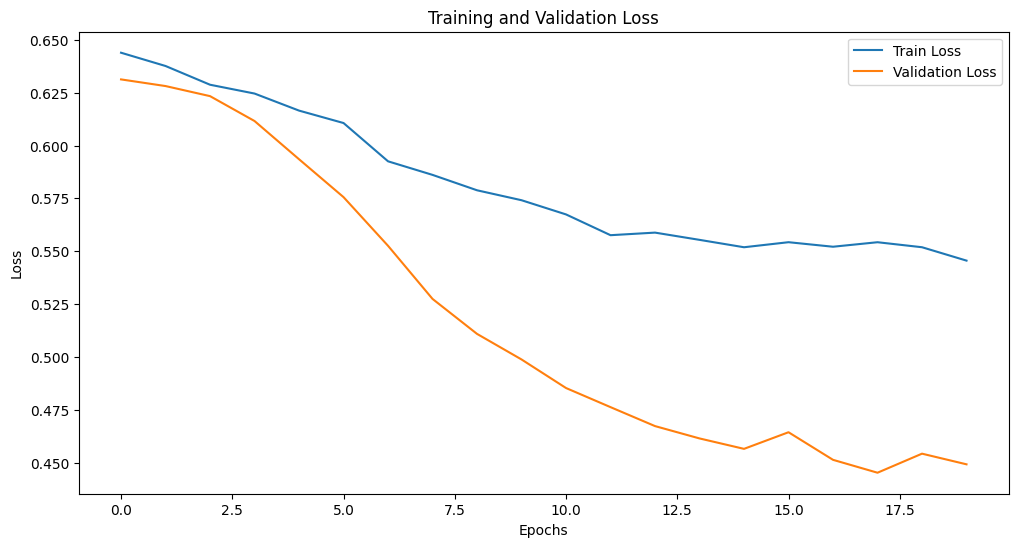

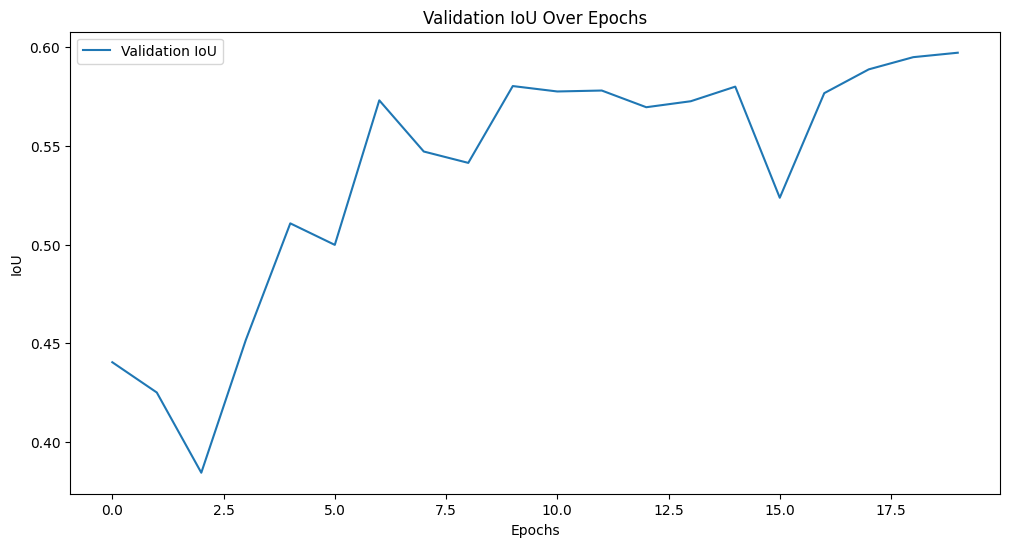

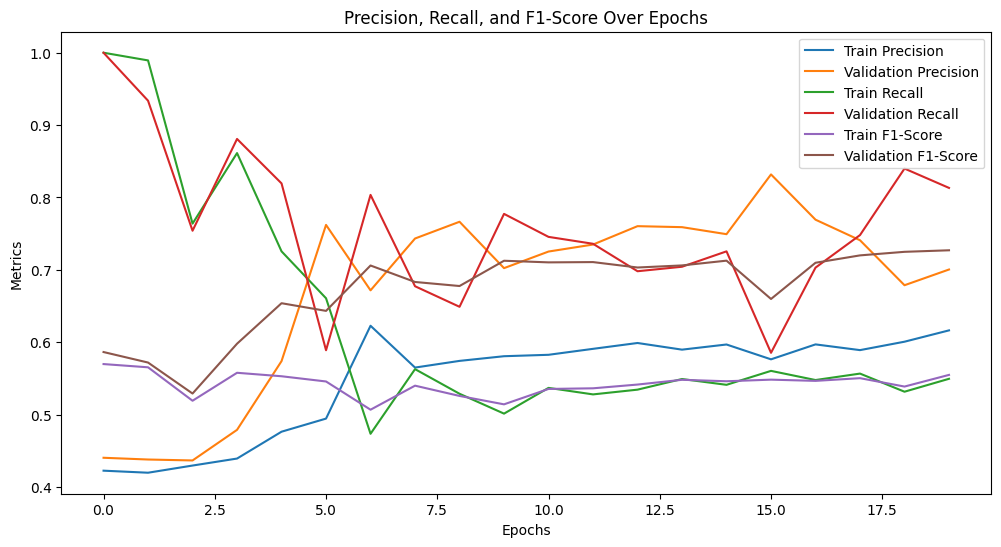

In [18]:
import matplotlib.pyplot as plt

# Gráfico de Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Gráfico de IoU
plt.figure(figsize=(12, 6))
plt.plot(val_ious, label="Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.title("Validation IoU Over Epochs")
plt.legend()
plt.show()

# Gráfico de Precision, Recall e F1-Score
plt.figure(figsize=(12, 6))
plt.plot(train_precisions, label="Train Precision")
plt.plot(val_precisions, label="Validation Precision")
plt.plot(train_recalls, label="Train Recall")
plt.plot(val_recalls, label="Validation Recall")
plt.plot(train_f1_scores, label="Train F1-Score")
plt.plot(val_f1_scores, label="Validation F1-Score")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Precision, Recall, and F1-Score Over Epochs")
plt.legend()
plt.show()


In [13]:


model.eval()
ious = []
with torch.no_grad():
    for images, masks in val_loader:
        outputs = model(images)
        iou = iou_score(outputs, masks)
        ious.append(iou)

print(f"IoU médio no conjunto de validação/teste: {sum(ious)/len(ious)}")


IoU médio no conjunto de validação/teste: 0.6014183853801928


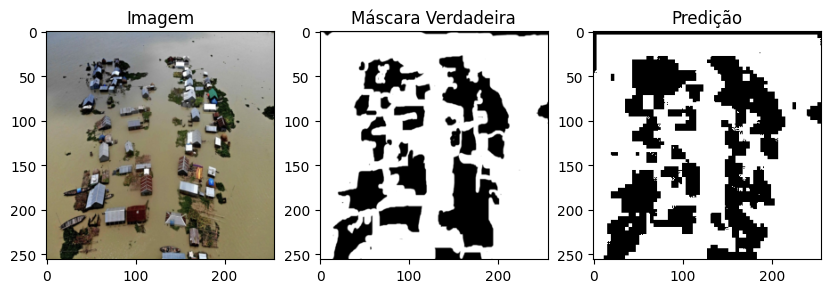

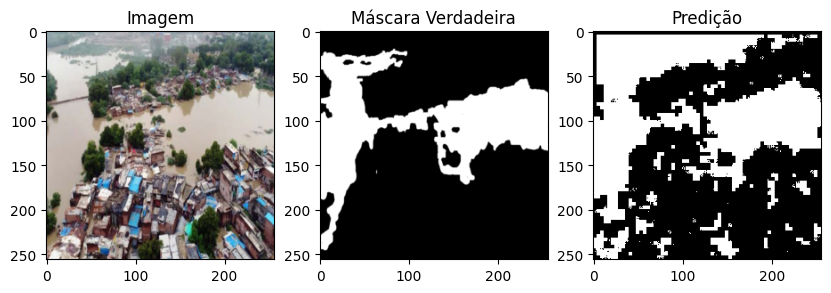

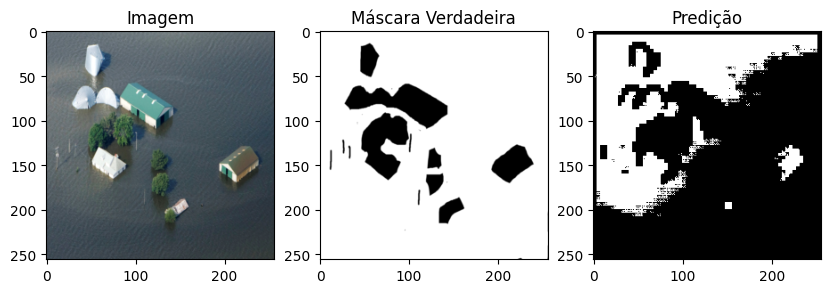

In [20]:
# Visualizar até 3 exemplos do conjunto de validação/teste
model.eval()
num_examples = 3  # Número de exemplos desejados
example_count = 0  # Contador de exemplos

with torch.no_grad():
    for images, masks in val_loader:
        batch_size = images.size(0)  # Tamanho do lote atual
        for i in range(batch_size):
            if example_count >= num_examples:
                break  # Pare se já tiver mostrado o número desejado de exemplos

            # Obtenha a predição e a máscara verdadeira
            pred = outputs[i, 0].cpu().numpy() > 0.5
            true_mask = masks[i, 0].cpu().numpy()

            # Exibir os gráficos
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.title("Imagem")
            plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())

            plt.subplot(1, 3, 2)
            plt.title("Máscara Verdadeira")
            plt.imshow(true_mask, cmap="gray")

            plt.subplot(1, 3, 3)
            plt.title("Predição")
            plt.imshow(pred, cmap="gray")

            plt.show()

            example_count += 1  # Incrementar o contador de exemplos

        if example_count >= num_examples:
            break  # Pare o loop principal se já tiver mostrado o número desejado de exemplos
